<a href="https://colab.research.google.com/github/babujyan/hateful_memes-hate_detectron/blob/main/finel_model_i_think.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Hub Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 10.8MB/s 


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [4]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 8.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 645kB 37.3MB/s 
     |████████████████████████████████| 1.2MB 33.7MB/s 
     |████████████████████████████████| 358kB 38.9MB/s 
     |████████████████████████████████| 706kB 39.5MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
     |████████████████████████████████| 174kB 35.3MB/s 


In [5]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import pickle

In [ ]:
import logging
from pathlib import Path

In [ ]:
data = pd.read_json("/content/drive/MyDrive/Facebook_Meme_Data/aca2021-meme-analysis-challenge/train.jsonl", lines=True)
images_path = '/content/drive/MyDrive/Facebook_Meme_Data/aca2021-meme-analysis-challenge/'

In [ ]:
img_height, img_width = 244,  244

In [ ]:
import shutil

In [ ]:
data.img[0]

'img/42953.png'

In [ ]:
target = '/content/drive/MyDrive/Facebook_Meme_Data/aca2021-meme-analysis-challenge/train/'
for i in data.img:
  shutil.copyfile(images_path + i, target + i)


In [ ]:
Daadata_dir = '/content/drive/MyDrive/Facebook_Meme_Data/aca2021-meme-analysis-challenge/img/'
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


TypeError: ignored

In [ ]:
data['img_data'] = data['id'].map(images_transformed)
data.head()

,id,img,label,text,img_data
0,42953,img/42953.png,0,its their character not their color that matters,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,13894,img/13894.png,0,putting bows on your pet,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
  def generator():
    for txt, img, l in zip(data.text, data.img_data, data.label):
      yield {"txt_input": procesor.predict(txt), "img_input": img}, int(l)

In [ ]:
  dataset = tf.data.Dataset.from_generator(generator,
                                           output_types=({
                                               "txt_input": tf.int64, 
                                               "img_input": tf.float32}, 
                                               tf.int64))

In [ ]:
# DATASET_SIZE = len(data)
# train_size = int(0.8 * DATASET_SIZE)
# # val_size = int(0.20 * DATASET_SIZE)

# train_data = data[:train_size]
# val_data = data[train_size:]


# train_img = tf.convert_to_tensor(np.array(train_data.img_data.to_list()).reshape(len(train_data), 25088))
# val_img = tf.convert_to_tensor(np.array(val_data.img_data.to_list()).reshape(len(val_data), 25088))
# train_img=tf.data.Dataset.from_tensor_slices((train_data.
# train_text = tf.convert_to_tensor(train_data.text.to_list())
# val_text = tf.convert_to_tensor(val_data.text.to_list())

# train_labels = tf.convert_to_tensor(train_data.label.to_list())
# val_labels = tf.convert_to_tensor(val_data.label.to_list())

In [ ]:
DATASET_SIZE = len(data)
train_size = int(0.8 * DATASET_SIZE)
# val_size = int(0.20 * DATASET_SIZE)

train_data = data[:train_size]
val_data = data[train_size:]

In [ ]:


# train_img=tf.data.Dataset.from_tensor_slices(( np.array(data[:train_size].img_data.to_list()).reshape(len(data[:train_size]), 25088)))
# val_img=tf.data.Dataset.from_tensor_slices(np.array(data[train_size:].img_data.to_list()).reshape(len(data[train_size:]), 25088))

# train_text =tf.data.Dataset.from_tensor_slices(np.array(data[:train_size].text.to_list()))
# val_text = tf.data.Dataset.from_tensor_slices(np.array(data[:train_size].text.to_list()))

# train_labels =tf.data.Dataset.from_tensor_slices(np.array(data[:train_size].label.to_list()))
# val_labels = tf.data.Dataset.from_tensor_slices(np.array(data[train_size:].label.to_list()))

# traintf.data.Dataset.from_tensor_slices(( np.array(data[:train_size].img_data.to_list()).reshape(len(data[:train_size]), 25088),np.array(data[:train_size].text.to_list()),np.array(data[:train_size].label.to_list())))

KeyboardInterrupt: ignored

In [ ]:
# train=tf.data.Dataset.from_tensor_slices(( 
#                                           np.array(data[:train_size].text.to_list()),
#                                           np.array(data[:train_size].img_data.to_list()).reshape(len(data[:train_size]), 25088),
#                                           np.array(data[:train_size].label.to_list())))



In [ ]:
text_train=np.array(data[:train_size].text)

In [ ]:
img_train=np.array(data[:train_size].img_data)

In [ ]:
label_train=np.array(data[:train_size].label)

In [ ]:
text_train

array(['its their character not their color that matters',
       "don't be afraid to love again everyone is not like your ex",
       'putting bows on your pet', ...,
       'the face they make when you\'ve left the "plantation" and you no longer think like them',
       'meanwhile at the isis strip club',
       'dude stop smoking its gonna harm you dude stop'], dtype=object)

In [ ]:
for i in range(6800):
  img_train[i]=img_train[i].tolist()

In [ ]:
# np.save('img_data', img_train)

In [ ]:
# img_train=data = np.load('img_data.npy',allow_pickle=True)

FileNotFoundError: ignored

In [ ]:
train_img2=tf.data.Dataset.from_tensor_slices(img_train)

ValueError: ignored

In [ ]:
img_train=img_train.tolist()

AttributeError: ignored

In [ ]:
# import tensorflow as t
# train_img2=tf.data.Dataset.from_tensor_slices(img_train)

# train_text2 =tf.data.Dataset.from_tensor_slices(text_train)


train_labels2 =tf.data.Dataset.from_tensor_slices(label_train)



In [ ]:
train=tf.data.Dataset.from_tensor_slices(((text_train,img_train),label_train))

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train=train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
```# with open('train_img.pickle', 'wb') as f:
#     pickle.dump(img_train, f)

In [ ]:
# val=tf.data.Dataset.from_tensor_slices((np.array(data[train_size:].text.to_list()),
#                                   np.array(data[train_size:].img_data.to_list()).reshape(len(data[train_size:]), 25088),
#                                     np.array(data[train_size:].label.to_list())))

In [ ]:
# BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100

# train_img = train_img.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# val_img = val_img.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# train_text = train_text.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# val_text = val_text.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# train_labels = train_labels.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# val_labels = val_labels.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# test_data = pd.read_json("drive/MyDrive/test.jsonl", lines=True)


In [ ]:
# test_data['img_data'] = test_data['id'].map(images_transformed)
# test_data.head()

,id,img,text,img_data
0,8291,img/08291.png,white people is this a shooting range,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,46971,img/46971.png,bravery at its finest,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3745,img/03745.png,your order comes to $37.50 and your white priv...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,83745,img/83745.png,it is time.. to send these parasites back to t...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,80243,img/80243.png,mississippi wind chime,"[[1.583276, 0.0, 0.0, 0.0, 9.846573, 0.0, 0.0,..."


In [ ]:
# test_ds = tf.data.Dataset.from_tensor_slices((test_data.text))

In [ ]:
# test_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [ ]:
#Data pipline 

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path    
tf.get_logger().setLevel('ERROR')
AUTOTUNE = tf.data.AUTOTUNE

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
img_height, img_width = 224, 224
image_count = 8500

In [3]:
text_path = "/content/drive/MyDrive/Facebook_Meme_Data/aca2021-meme-analysis-challenge/train.jsonl"

text_dataset = tf.data.TextLineDataset(text_path)
text_dataset = text_dataset.shuffle(image_count, reshuffle_each_iteration=False)

In [4]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [5]:
img_path = '/content/drive/MyDrive/Facebook_Meme_Data/aca2021-meme-analysis-challenge/img/'

def process_path(text_l):
    text_l = tf.strings.regex_replace(text_l, '"', '')


    parts = tf.strings.split(text_l, ":", maxsplit=-1)
    
    
    label = parts[3]
    label = tf.strings.split(label, ",")[0]
    label = tf.strings.to_number(label, tf.int32) 

    text = parts[-1]
    
    file_path = parts[1]
    file_path = tf.strings.split(file_path, ",")[0]

    file_path = tf.cond(tf.strings.length(file_path) == tf.constant(4), 
                        lambda: tf.add("0", file_path), lambda: file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(img_path+file_path+".png")
    img = decode_img(img)
    return {"img_input": img, "text_input": text}, {"classifier": label}

In [6]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
text_dataset = text_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [7]:
val_size = int(image_count * 0.2)
train_ds = text_dataset.skip(val_size)
val_ds = text_dataset.take(val_size)

In [8]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [9]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
# test_path = "/content/drive/MyDrive/Facebook_Meme_Data/aca2021-meme-analysis-challenge/test.jsonl"

# test_dataset = tf.data.TextLineDataset(test_path)
# # test_dataset = text_dataset.shuffle(image_count, reshuffle_each_iteration=False)

# # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
# test_dataset  = configure_for_performance(test_dataset)

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [13]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'electra_base'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

Let's try the preprocessing model on some text and see the output:

As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use just follow the model's url for documentation. Here specifically you don't need to worry about it because the preprocessing model will take care of that for you.


In [10]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16

In [11]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(128, activation='relu')(net)



  model = VGG16(include_top=False, input_shape=(224,224,3))
  model.layers[0]._name = "img_input"
  # mark loaded layers as not trainable
  # for layer in model.layers:
  #     layer.trainable = False
  # add new classifier layers
  flat1 = tf.keras.layers.Flatten()(model.layers[-1].output)
  img_l = tf.keras.layers.Dropout(0.1)(flat1)
  class1 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(img_l)
  class1 = tf.keras.layers.concatenate([net, class1])
  pre_out = tf.keras.layers.Dense(64, activation='relu')(class1)
  net = tf.keras.layers.Dropout(0.1)(pre_out)

  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(pre_out)
  # return tf.keras.Model(inputs=model.inputs, outputs=net)
  return tf.keras.Model(inputs=[model.inputs,text_input], outputs=[net])

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

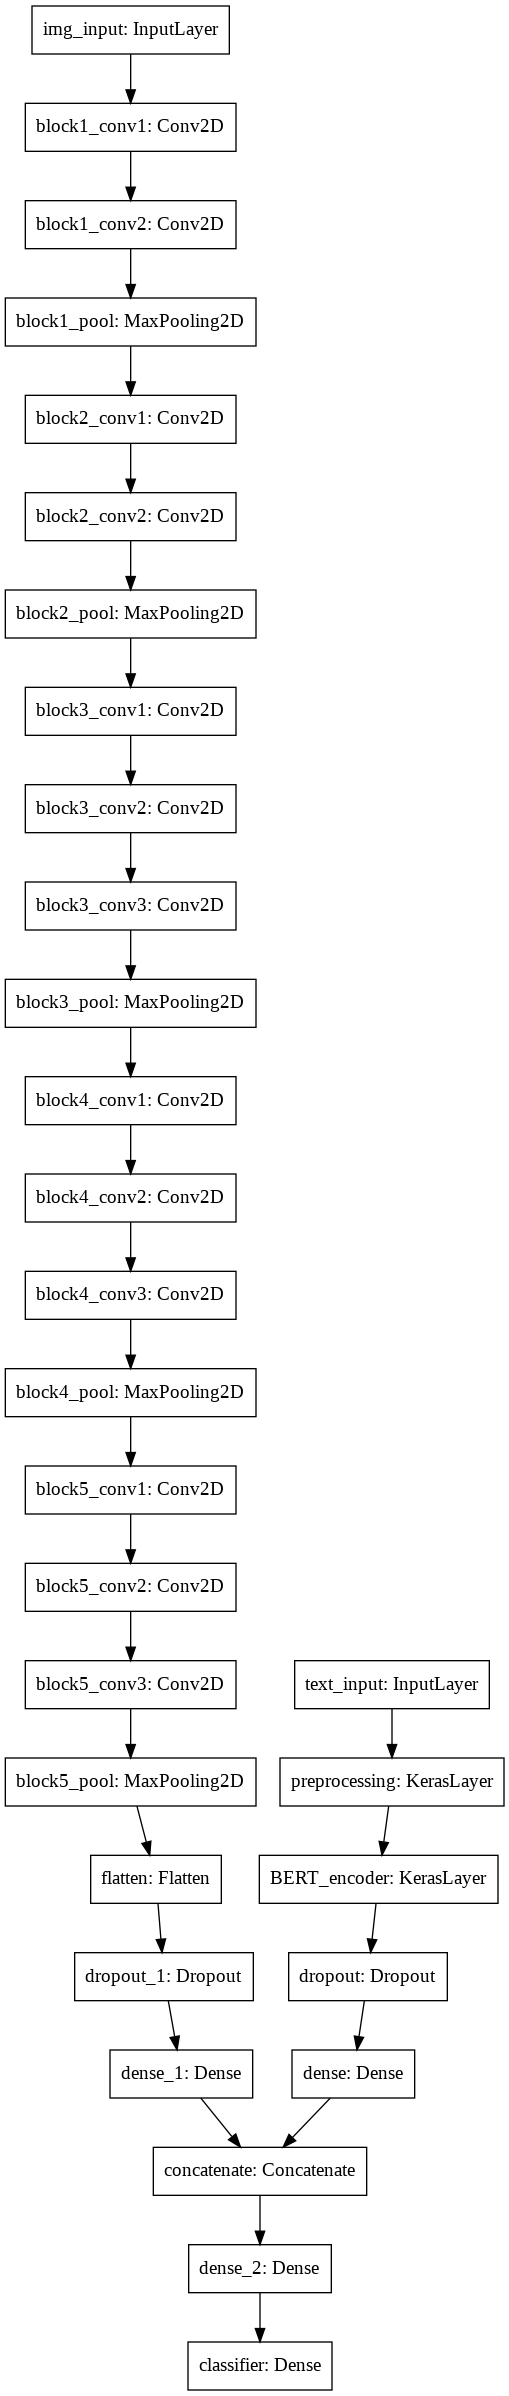

In [19]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        img_input[0][0]                  
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
txt_input (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           txt_input[0][0]                  
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
tf.data.experimental.cardinality(train_ds).numpy()

-2

In [16]:
epochs = 5
steps_per_epoch = 213
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [19]:
classifier_model.compile(
    optimizer=optimizer,
                        # optimizer=tf.keras.optimizers.Adam(3e-5),
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [20]:
print(f'Training model with {tfhub_handle_encoder}')
import datetime
import os
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)
history = classifier_model.fit(train_ds,
                               validation_data=val_ds,
                              epochs=5,
                               callbacks=[callback]
                              )

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/5
     22/Unknown - 137s 4s/step - loss: 1.3915 - binary_accuracy: 0.5557 - auc: 0.4985

ResourceExhaustedError: ignored

# MInchev stex kanes

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
classifier_model.metrics_names

['loss', 'auc']

In [1]:
loss, accuracy = classifier_model.evaluate(val_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

NameError: ignored

In [ ]:
pred = tf.sigmoid(classifier_model.predict({"img_input":tf.convert_to_tensor(np.array(test_data.img_data.to_list()).reshape(len(test_data), 25088)),
                              "txt_input":tf.convert_to_tensor(test_data.text.to_list())}))

NameError: ignored

In [ ]:
import numpy as np

In [ ]:
classifier_model.predict(test_dataset)

InvalidArgumentError: ignored

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
predictions = {}
pred_np = np.array(pred)
for i, id in enumerate(test_data.id):
    # predictions[id] = 1 if pred_np[i][0] > 0.5 else 0
    predictions[id] = pred_np[i][0]

In [ ]:
pd.DataFrame(predictions.items(), columns=['id', "label"]).to_csv("predictions.csv")

In [ ]:
predictions

{1268: 1.0,
 1456: 0.99856526,
 1726: 0.99887186,
 1742: 0.9999999,
 1765: 1.0,
 1768: 0.9999968,
 1796: 0.11837333,
 1925: 0.999974,
 1967: 0.99998474,
 2143: 1.0,
 2145: 1.0,
 2157: 1.0,
 2364: 0.99999714,
 2478: 0.9999987,
 2518: 0.9999058,
 2568: 0.999405,
 2593: 0.9998301,
 2634: 0.9999981,
 2783: 0.9952651,
 3197: 0.9998964,
 3214: 0.9999999,
 3217: 0.99827135,
 3519: 0.93836755,
 3524: 0.9265623,
 3567: 0.9862757,
 3568: 0.99998224,
 3594: 0.99999976,
 3745: 0.9999999,
 3798: 1.0,
 3928: 0.99999654,
 4538: 1.0,
 4569: 0.9963767,
 4621: 0.9999982,
 4769: 0.9623619,
 4857: 0.9999652,
 5126: 1.0,
 5213: 0.99933165,
 5279: 0.9999918,
 5316: 0.999969,
 5349: 0.9999932,
 5439: 1.0,
 5618: 0.99999917,
 5938: 0.9996113,
 6123: 0.085342936,
 6273: 1.0,
 6352: 0.99999964,
 6491: 0.9999976,
 6582: 0.9999999,
 6723: 1.0,
 7135: 0.99276155,
 7198: 0.99999964,
 7351: 0.99999964,
 7382: 0.97491324,
 7429: 0.99999976,
 7528: 0.99996877,
 7653: 0.99985623,
 8291: 0.9587201,
 8319: 0.99999774,
 8

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


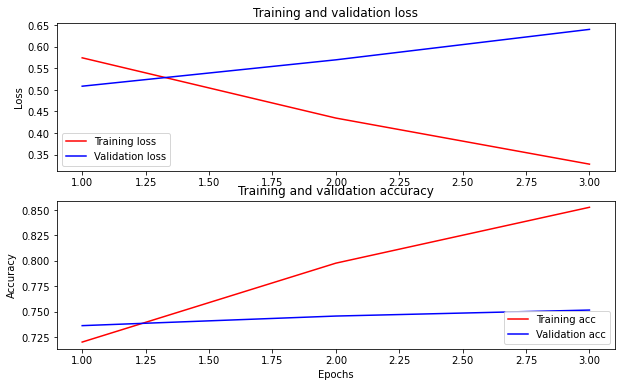

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [ ]:
dataset_name = 'aca'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save("drive/MyDrive/aca", include_optimizer=False)

Mounted at /content/drive


Let's reload the model so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu) which runs on a TPU and shows you how to work with multiple inputs.